<a href="https://colab.research.google.com/github/starkjiang/TrAC-RL/blob/main/m3_rl_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Actor-Critic (AC) for Lunar Lander

In this tutorial, we will implement Actor-Critic for the environment of Lunar Lander in OpenAI `gym`. The Lunar Lander environment is part of [Box2D environments](https://www.gymlibrary.dev/environments/box2d/).

**Description of Lunar Lander**

This environment is a classic rocket trajectory optimization problem. According to Pontryagin's maximum principle, it is optimal to fire the engine at full throttle or turn it off. This is the reason why this environment has discrete actions: engine on or off. There are two environment versions: discrete or continuous. The landing pad is always at coordinates (0,0). The coordinates are the first two numbers in the state vector. Landing outside of the landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land on its first attempt.

**Action Space**

There are four discrete actions available: do nothing, fire left orientation engine, fire main engine, fire right orientation engine.

**Observation Space**

The state is an 8-dimensional vector: the coordinates of the lander in `x` & `y`, its linear velocities in `x` & `y`, its angle, its angular velocity, and two booleans that represent whether each leg is in contact with the ground or not.

**Rewards**

Reward for moving from the top of the screen to the landing pad and coming to rest is about 100-140 points. If the lander moves away from the landing pad, it loses reward. If the lander crashes, it receives an additional -100 points. If it comes to rest, it receives an additional +100 points. Each leg with ground contact is +10 points. Firing the main engine is -0.3 points each frame. Firing the side engine is -0.03 points each frame. Solved is 200 points.

**Starting State**

The lander starts at the top center of the viewport with a random initial force applied to its center of mass.

**Episode Termination**

The episode finishes if:

1.   the lander crashes (the lander body gets in contact with the moon);
2.   the lander gets outside of the viewport `(x` coordinate is greater than 1);
3.   the lander is not awake. From the Box2D docs, a body which is not awake is a body which doesn't move and doesn't collide with any other body.

The tutorial is adapted from an [online example](https://github.com/bentrevett/pytorch-rl/blob/master/2%20-%20Actor%20Critic%20%5BCartPole%5D.ipynb).


In [30]:
# !pip install swig
# !pip install gymnasium[box2d]
# Import modules.
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.distributions as distributions
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tqdm
import typing

# Call the CartPole env for both trainig and testing.
train_env = gym.make('LunarLander-v3')
test_env = gym.make('LunarLander-v3')

# Set random seeds for different envs.
SEED = 42

train_env.reset(seed=SEED)
test_env.reset(seed=SEED+1)
np.random.seed(SEED)
torch.manual_seed(SEED)
print('State shape: ', train_env.observation_space.shape)
print('Number of actions: ', train_env.action_space.n)

# If GPU is to be used.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

State shape:  (8,)
Number of actions:  4


# Define Actor and Critic

In [31]:
# We first define a base model class for actor and critic.
class MLP(nn.Module):
    """Base class for MLPs."""
    def __init__(self,
        input_dim: int = train_env.observation_space.shape[0],
        hidden_dim: int = 128,
        output_dim: int = train_env.action_space.n,
        dropout: float = 0.1,
    ):
        """Initialize the MLP.

        Args:
            input_dim (int): Input dimension.
            hidden_dim (int): Hidden dimension.
            output_dim (int): Output dimension.
            dropout (float, optional): Dropout rate. Defaults to 0.1.
        """
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass."""
        x = self.net(x)
        return x

class ActorCritic(nn.Module):
    """Actor-Critic model."""
    def __init__(self, actor, critic):
        """Initialize the Actor-Critic model.

        Args:
            actor (nn.Module): Actor network.
            critic (nn.Module): Critic network.
        """
        super().__init__()

        self.actor = actor
        self.critic = critic

    def forward(self, state):
        """Forward pass."""

        action_pred = self.actor(state)
        value_pred = self.critic(state)

        return action_pred, value_pred

# Initialize the actor and critic.
actor = MLP()
critic = MLP(output_dim=1)

agent = ActorCritic(actor, critic)

# Define a weight initialization function.
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0)

agent.apply(init_weights)

ActorCritic(
  (actor): MLP(
    (net): Sequential(
      (0): Linear(in_features=8, out_features=128, bias=True)
      (1): Dropout(p=0.1, inplace=False)
      (2): ReLU()
      (3): Linear(in_features=128, out_features=128, bias=True)
      (4): Dropout(p=0.1, inplace=False)
      (5): ReLU()
      (6): Linear(in_features=128, out_features=4, bias=True)
    )
  )
  (critic): MLP(
    (net): Sequential(
      (0): Linear(in_features=8, out_features=128, bias=True)
      (1): Dropout(p=0.1, inplace=False)
      (2): ReLU()
      (3): Linear(in_features=128, out_features=128, bias=True)
      (4): Dropout(p=0.1, inplace=False)
      (5): ReLU()
      (6): Linear(in_features=128, out_features=1, bias=True)
    )
  )
)

# Train and Evaluate Functions

In [32]:
Tensors = typing.Tuple[torch.Tensor, torch.Tensor, torch.Tensor]
def train(
    env: gym.Env,
    agent: nn.Module,
    optimizer: optim.Optimizer,
    discount_factor: float,
) -> Tensors:
    """Train the policy.

    Args:
        env (gym.Env): Environment.
        agent (nn.Module): The Actor-Critic agent.
        optimizer (optim.Optimizer): Optimizer.
        discount_factor (float): Discount factor.

    Returns:
        policy_loss (torch.Tensor): Policy loss.
        value_loss (torch.Tensor): Value loss.
        episode_reward (torch.Tensor): Episode reward.
    """

    agent.train()

    log_prob_actions = []
    values = []
    rewards = []
    done = False
    episode_reward = 0

    state, _ = env.reset()

    while not done:

        state = torch.FloatTensor(state).unsqueeze(0)
        # Get the predictive action and value.
        action_pred, value_pred = agent(state)
        # Get the action probability.
        action_prob = F.softmax(action_pred, dim = -1)
        # Creates a categorical distribution parameterized by action
        # probability.
        dist = distributions.Categorical(action_prob)
        # Sample an action from the distribution.
        action = dist.sample()
        # Calculate its log probability.
        log_prob_action = dist.log_prob(action)
        # Execute the action in the environment.
        state, reward, terminated, truncted, _ = env.step(action.item())
        # Save the log probability action, value, and reward.
        log_prob_actions.append(log_prob_action)
        values.append(value_pred)
        rewards.append(reward)

        episode_reward += reward
        done = terminated or truncted

    log_prob_actions = torch.cat(log_prob_actions)
    values = torch.cat(values).squeeze(-1)
    # Calculate the returns.
    returns = calculate_returns(rewards, discount_factor)
    # Update the actor and critic.
    policy_loss, value_loss = update_policy(
        returns,
        log_prob_actions,
        values,
        optimizer
    )

    return policy_loss, value_loss, episode_reward

def calculate_returns(
    rewards: torch.Tensor,
    discount_factor: float,
    normalize: bool = True,
) -> torch.Tensor:
    """Calculate the returns.

    Args
        rewards (torch.Tensor): Rewards.
        discount_factor (float): Discount factor.
        normalize (bool, optional): Whether to normalize the returns.
            Defaults to True.

    Returns:
        returns (torch.Tensor): Returns.
    """

    returns = []
    R = 0
    # We calculate the return at each step using the back-tracing way.
    for r in reversed(rewards):
        R = r +  R * discount_factor
        returns.insert(0, R)

    returns = torch.tensor(returns)

    if normalize:
        returns = (returns - returns.mean()) / returns.std()

    return returns

def update_policy(
    returns: torch.Tensor,
    log_prob_actions: torch.Tensor,
    values: torch.Tensor,
    optimizer: optim.Optimizer,
) -> typing.Tuple[float, float]:
    """Update the policy.

    Args:
        returns (torch.Tensor): Returns.
        log_prob_actions (torch.Tensor): Log probability actions.
        values (torch.Tensor): Values.
        optimizer (optim.Optimizer): Optimizer.

    Returns:
        policy_loss (float): Policy loss.
        value_loss (float): Value loss.
    """

    returns = returns.detach()
    # Calculate the policy network loss. See the policy gradient.
    policy_loss = - (returns * log_prob_actions).sum()
    # Calculate the value loss.
    value_loss = F.smooth_l1_loss(returns, values).sum()

    optimizer.zero_grad()

    policy_loss.backward()
    value_loss.backward()

    optimizer.step()

    return policy_loss.item(), value_loss.item()


def evaluate(
    env: gym.Env,
    agent: nn.Module,
) -> torch.Tensor:
    """Evaluate the agent.

    Args:
        env (gym.Env): Environment.
        agent (nn.Module): The Actor-Critic agent.

    Returns:
        episode_reward (torch.Tensor): Episode reward.
    """

    agent.eval()

    rewards = []
    done = False
    episode_reward = 0
    state, _ = env.reset()
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            action_pred, _ = agent(state)
            action_prob = F.softmax(action_pred, dim = -1)
        action = torch.argmax(action_prob, dim = -1)
        state, reward, terminated, truncated, _ = env.step(action.item())
        episode_reward += reward
        done = terminated or truncated

    return episode_reward

# Loop for Training and Evaluation

| Episode:  10 | Mean Train Rewards: -225.1 | Mean Test Rewards: -271.5 |
| Episode:  20 | Mean Train Rewards: -204.7 | Mean Test Rewards: -254.3 |
| Episode:  30 | Mean Train Rewards: -169.6 | Mean Test Rewards: -309.2 |
| Episode:  40 | Mean Train Rewards: -146.7 | Mean Test Rewards: -279.0 |
| Episode:  50 | Mean Train Rewards: -111.9 | Mean Test Rewards: -248.8 |
| Episode:  60 | Mean Train Rewards: -152.6 | Mean Test Rewards: -314.5 |
| Episode:  70 | Mean Train Rewards: -166.2 | Mean Test Rewards: -289.8 |
| Episode:  80 | Mean Train Rewards: -141.3 | Mean Test Rewards: -185.9 |
| Episode:  90 | Mean Train Rewards: -75.3 | Mean Test Rewards: -161.7 |
| Episode: 100 | Mean Train Rewards: -85.1 | Mean Test Rewards: -221.2 |
| Episode: 110 | Mean Train Rewards: -85.2 | Mean Test Rewards: -283.2 |
| Episode: 120 | Mean Train Rewards: -59.6 | Mean Test Rewards: -209.5 |
| Episode: 130 | Mean Train Rewards: -85.0 | Mean Test Rewards: -149.7 |
| Episode: 140 | Mean Train Rewards: -71.5 

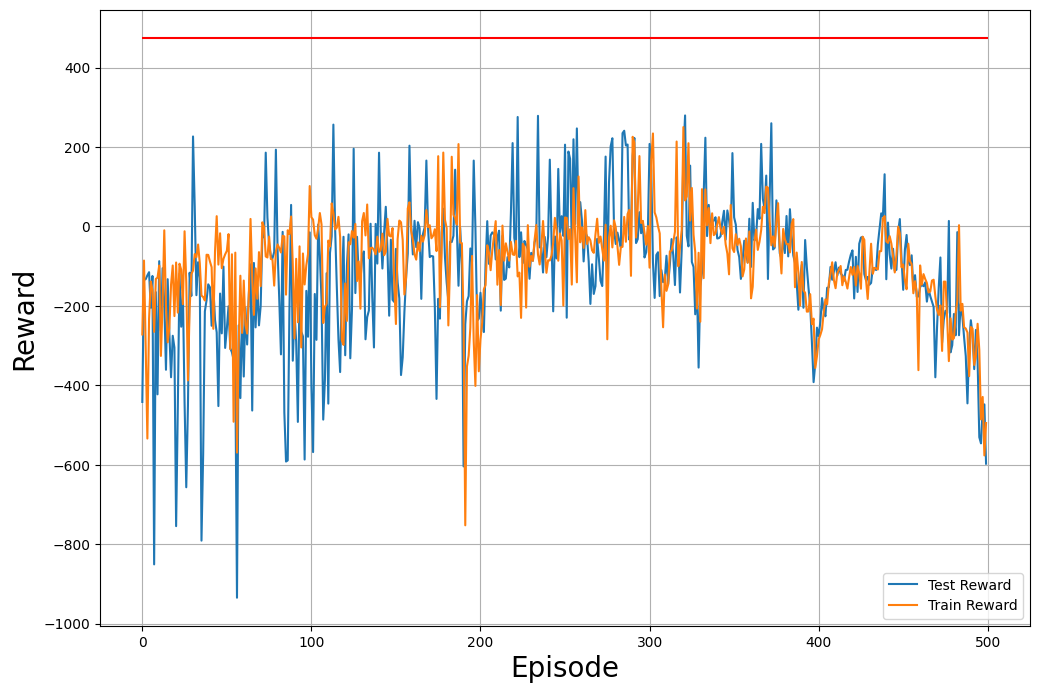

In [33]:
MAX_EPISODES = 500
DISCOUNT_FACTOR = 0.99
N_TRIALS = 25
REWARD_THRESHOLD = 475
PRINT_EVERY = 10
LEARNING_RATE = 1e-2

train_rewards = []
test_rewards = []

for episode in range(1, MAX_EPISODES+1):
    optimizer = optim.Adam(agent.parameters(), lr=LEARNING_RATE)

    policy_loss, critic_loss, train_reward = train(
        train_env,
        agent,
        optimizer,
        DISCOUNT_FACTOR
    )

    test_reward = evaluate(test_env, agent)

    train_rewards.append(train_reward)
    test_rewards.append(test_reward)

    mean_train_rewards = np.mean(train_rewards[-N_TRIALS:])
    mean_test_rewards = np.mean(test_rewards[-N_TRIALS:])

    if episode % PRINT_EVERY == 0:
        print(f'| Episode: {episode:3} | Mean Train Rewards: {mean_train_rewards:5.1f} | Mean Test Rewards: {mean_test_rewards:5.1f} |')

    if mean_test_rewards >= REWARD_THRESHOLD:
        print(f'Reached reward threshold in {episode} episodes')
        break

# Plotting.
plt.figure(figsize=(12,8))
plt.plot(test_rewards, label='Test Reward')
plt.plot(train_rewards, label='Train Reward')
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Reward', fontsize=20)
plt.hlines(REWARD_THRESHOLD, 0, len(test_rewards), color='r')
plt.legend(loc='lower right')
plt.grid()